In [ ]:
# Install rapidsai (GPU)
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

# Install SHAP package with GPU support
!sudo apt install nvidia-cuda-toolkit
!export CUDA_PATH=/usr
!git clone https://github.com/shap/shap.git
!cd ./shap && python setup.py install --user

In [ ]:
# Check SHAP package
!ls -al /root/.local/lib/python3.10/site-packages/

In [ ]:
# Heat map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
features_file = './drive/MyDrive/Colab Notebooks/iteration-v2/v2_dataset_url_https_tls_lexical_pdns_features.csv'
df = pd.read_csv(features_file)

# Drop the 'url' column
df.drop(columns=['url'], inplace=True)

# Drop the 'domain' column
df.drop(columns=['domain'], inplace=True)

# Drop the 'tld' column
df.drop(columns=['tld'], inplace=True)

# Drop the 'uses_punycode' column
# df.drop(columns=['uses_punycode'], inplace=True)

# Calculate the correlation matrix
corrmat = df.corr()

# Identify the target variable
target_variable = 'label'

# Calculate correlations with the target variable
correlations = corrmat[target_variable].drop(target_variable)  # Exclude the target variable itself
low_correlation_features = correlations[correlations.abs() < 0.1]  # Threshold set at 0.1

# Visualize the correlation matrix
f, ax = plt.subplots(figsize=(35, 30))
sns.heatmap(corrmat, square=True, annot=True, annot_kws={'size': 8})

# Highlight low correlation features
for feature in low_correlation_features.index:
    idx = corrmat.columns.get_loc(feature)
    ax.add_patch(plt.Rectangle((idx, idx), 1, 1, fill=False, edgecolor='blue', lw=3))

plt.show()

# Print features with low correlation
print("\n\nFeatures with low correlation with the target variable:")
for feature, correlation in low_correlation_features.items():
    print(f"{feature}: {correlation:.2f}")

# Sort the correlations from highest to lowest
sorted_correlations = correlations.sort_values(ascending=False)

# Print features sorted by correlation
print("\n\nFeatures sorted by correlation with the target variable:")
for feature, correlation in sorted_correlations.items():
    print(f"{feature}: {correlation:.2f}")

Output hidden; open in https://colab.research.google.com to view.

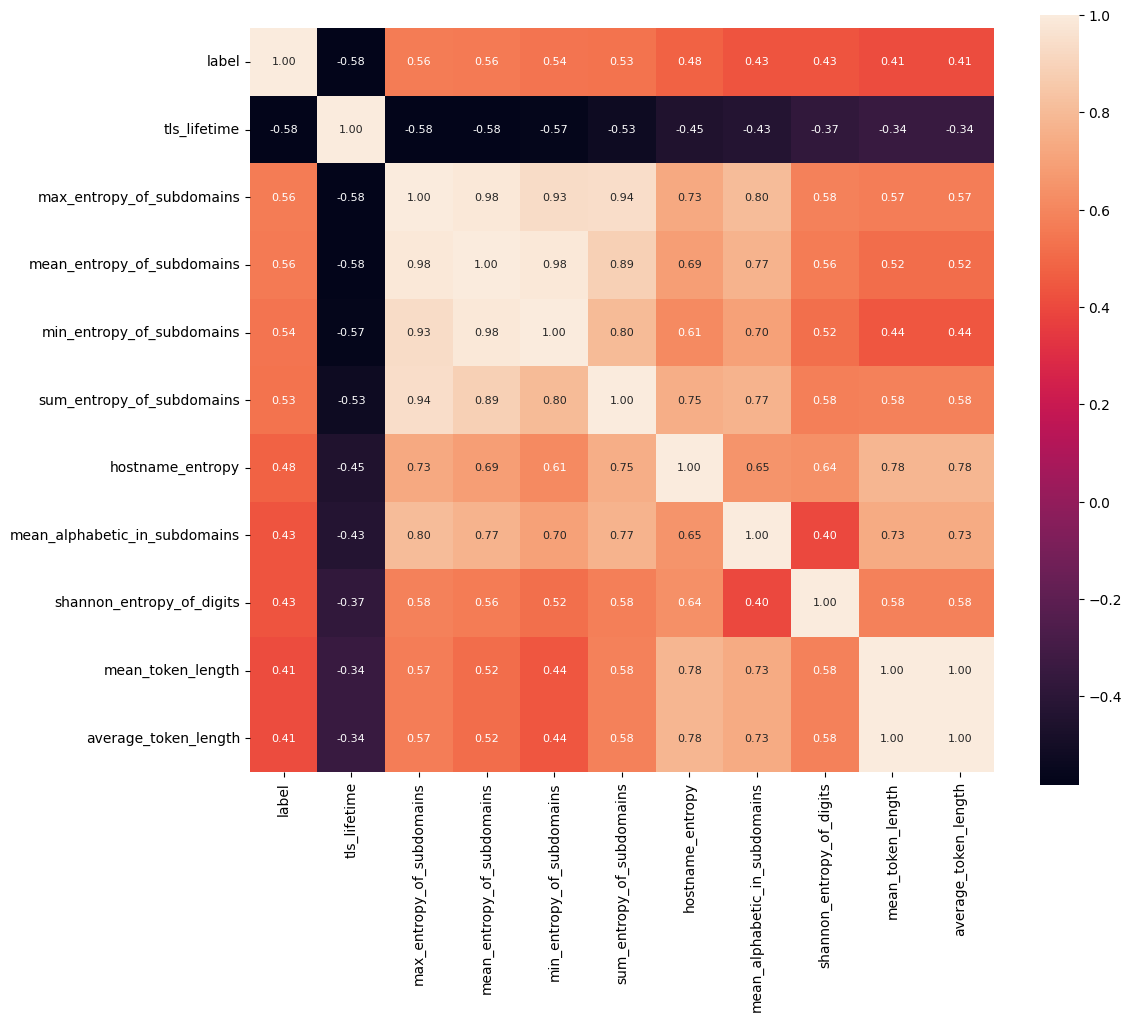



Top 10 features sorted by correlation with the target variable:
tls_lifetime: -0.58
max_entropy_of_subdomains: 0.56
mean_entropy_of_subdomains: 0.56
min_entropy_of_subdomains: 0.54
sum_entropy_of_subdomains: 0.53
hostname_entropy: 0.48
mean_alphabetic_in_subdomains: 0.43
shannon_entropy_of_digits: 0.43
mean_token_length: 0.41
average_token_length: 0.41


In [6]:
# TOP-10 Heat Map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
features_file = './drive/MyDrive/Colab Notebooks/iteration-v2/v2_dataset_url_https_tls_lexical_pdns_features.csv'
df = pd.read_csv(features_file)

# Drop the 'url', 'domain', and 'tld' columns
df.drop(columns=['url', 'domain', 'tld'], inplace=True)

# Calculate the correlation matrix
corrmat = df.corr()

# Identify the target variable
target_variable = 'label'

# Calculate correlations with the target variable
correlations = corrmat[target_variable].drop(target_variable)  # Exclude the target variable itself

# Sort the correlations from highest to lowest and get the top 10 features
top_10_features = correlations.abs().sort_values(ascending=False).head(10).index

# Ensure 'label' is the first in the list of features
features_to_plot = [target_variable] + top_10_features.tolist()

# Filter the correlation matrix to include only the top 10 features and the target variable
top_corrmat = corrmat.loc[features_to_plot, features_to_plot]

# Visualize the filtered correlation matrix with 'label' first
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(top_corrmat, square=True, annot=True, annot_kws={'size': 8}, fmt='.2f')
plt.show()

# Print the top 10 features sorted by correlation
print("\n\nTop 10 features sorted by correlation with the target variable:")
for feature in top_10_features:
    print(f"{feature}: {correlations[feature]:.2f}")


In [ ]:
# All Features
import pandas as pd
import numpy as np
from cuml.metrics import roc_auc_score as gpu_roc_auc_score
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.pipeline import Pipeline
from cuml.ensemble import RandomForestClassifier as cumlRandomForestClassifier
from cuml.svm import SVC as cumlSVC
from cuml.neighbors import KNeighborsClassifier as cumlKNeighborsClassifier
import xgboost as xgb
import cudf
from cuml.compose import ColumnTransformer
from sklearn.metrics import classification_report
import cupy as cp

# Read the CSV file
features_file = './drive/MyDrive/Colab Notebooks/iteration-v2/v2_dataset_url_https_tls_lexical_pdns_features.csv'
df = pd.read_csv(features_file)

# Drop the 'url' column
df.drop(columns=['url'], inplace=True)

# Drop the 'domain' column
df.drop(columns=['domain'], inplace=True)

# Drop the 'tld' column
df.drop(columns=['tld'], inplace=True)

# Identify numerical features (to makesure)
numerical_features = df.columns.difference(['label'])

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# Convert numerical features to float32 for GPU compatibility
X[numerical_features] = X[numerical_features].astype(np.float32)

# Convert pandas DataFrame to cuDF DataFrame
X = cudf.DataFrame.from_pandas(X)
y = cudf.Series(y)

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # To keep any columns that are not specified in transformers
)

# Split the data into training and test sets, use stratify for balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert cuDF DataFrame to CuPy arrays for XGBoost
X_train_cupy = X_train.to_cupy()
X_test_cupy = X_test.to_cupy()
y_train_cupy = y_train.to_cupy()
y_test_cupy = y_test.to_cupy()

# Create preprocessing and modeling pipelines
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cumlRandomForestClassifier(random_state=42, n_streams=1))
])

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cumlSVC(random_state=42, probability=True)) # Set probability for ROC-AUC
])

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cumlKNeighborsClassifier())
])

# Train and evaluate XGBoost with updated parameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist', device='cuda')
xgb_model.fit(X_train_cupy, y_train_cupy)

# Train other models (RF, SVM, kNN)
rf_pipeline.fit(X_train, y_train)
svm_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_svm = svm_pipeline.predict(X_test)
y_pred_knn = knn_pipeline.predict(X_test)
y_pred_xgb = cp.asarray(xgb_model.predict(X_test_cupy))  # Ensure predictions are in CuPy array format
xgb_accuracy = (y_pred_xgb == y_test_cupy).mean()


print("Random Forest accuracy (cuML):", rf_pipeline.score(X_test, y_test))
print("SVM accuracy (cuML):", svm_pipeline.score(X_test, y_test))
print("kNN accuracy (cuML):", knn_pipeline.score(X_test, y_test))
print("XGBoost accuracy (cuML):", xgb_accuracy)

# Predict the probabilities for the positive class (class 1)
# Get the predicted probabilities for ROC-AUC calculation
y_pred_rf_proba = rf_pipeline.predict_proba(X_test).iloc[:, 1].to_numpy()
y_pred_svm_proba = svm_pipeline.predict_proba(X_test).iloc[:, 1].to_numpy()
y_pred_knn_proba = knn_pipeline.predict_proba(X_test).iloc[:, 1].to_numpy()
y_pred_xgb_proba = xgb_model.predict_proba(X_test_cupy)[:, 1]

# Calculate ROC-AUC Score using cuML (GPU)
# https://www.shiksha.com/online-courses/articles/roc-auc-vs-accuracy
# Calculate ROC-AUC Scores using cuML (GPU)
roc_auc_rf_gpu = gpu_roc_auc_score(y_test_cupy, cp.asarray(y_pred_rf_proba))
roc_auc_svm_gpu = gpu_roc_auc_score(y_test_cupy, cp.asarray(y_pred_svm_proba))
roc_auc_knn_gpu = gpu_roc_auc_score(y_test_cupy, cp.asarray(y_pred_knn_proba))
roc_auc_xgb_gpu = gpu_roc_auc_score(y_test_cupy, y_pred_xgb_proba)

print("\n\nRandom Forest ROC-AUC Score (GPU):", roc_auc_rf_gpu)
print("SVM ROC-AUC Score (GPU):", roc_auc_svm_gpu)
print("kNN ROC-AUC Score (GPU):", roc_auc_knn_gpu)
print("XGBoost ROC-AUC Score (GPU):", roc_auc_xgb_gpu)

# Convert cuDF Series to NumPy arrays for classification_report
y_test_np = y_test.to_numpy()
y_pred_rf_np = y_pred_rf.to_numpy()
y_pred_svm_np = y_pred_svm.to_numpy()
y_pred_knn_np = y_pred_knn.to_numpy()
y_pred_xgb_np = cp.asnumpy(y_pred_xgb)  # Convert CuPy array to NumPy array

# Evaluate Random Forest
print("\n\nRandom Forest Classification Report:")
print(classification_report(y_test_np, y_pred_rf_np))

# Evaluate SVM
print("SVM Classification Report:")
print(classification_report(y_test_np, y_pred_svm_np))

# Evaluate kNN
print("kNN Classification Report:")
print(classification_report(y_test_np, y_pred_knn_np))

# Evaluate XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test_np, y_pred_xgb_np))

[W] [21:43:24.902270] Random state is currently ignored by probabilistic SVC
Random Forest accuracy (cuML): 0.9131685495376587
SVM accuracy (cuML): 0.8869714140892029
kNN accuracy (cuML): 0.8815298676490784
XGBoost accuracy (cuML): 0.9264614427860697


Random Forest ROC-AUC Score (GPU): 0.9673810601234436
SVM ROC-AUC Score (GPU): 0.9499946236610413
kNN ROC-AUC Score (GPU): 0.9366539716720581
XGBoost ROC-AUC Score (GPU): 0.9746691584587097


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5461
           1       0.95      0.90      0.92      7403

    accuracy                           0.91     12864
   macro avg       0.91      0.92      0.91     12864
weighted avg       0.92      0.91      0.91     12864

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      5461
           1       0.91      0.90      0.90      7403



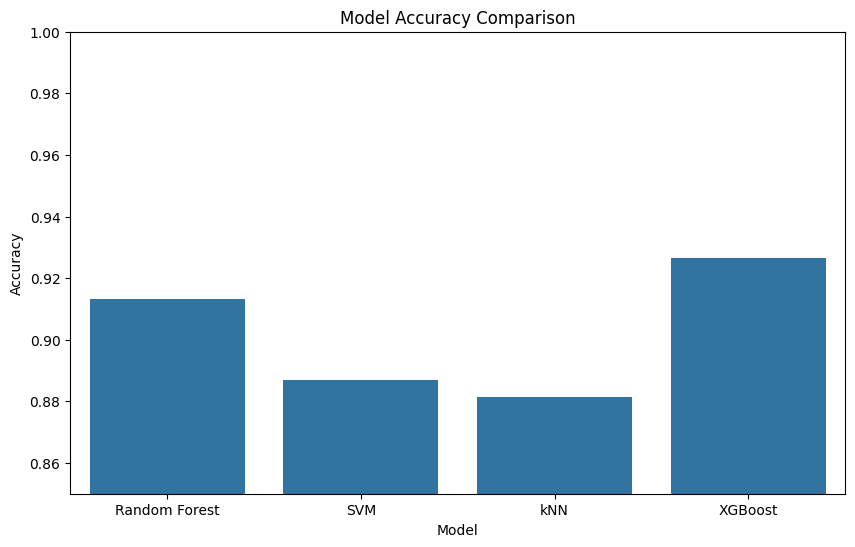

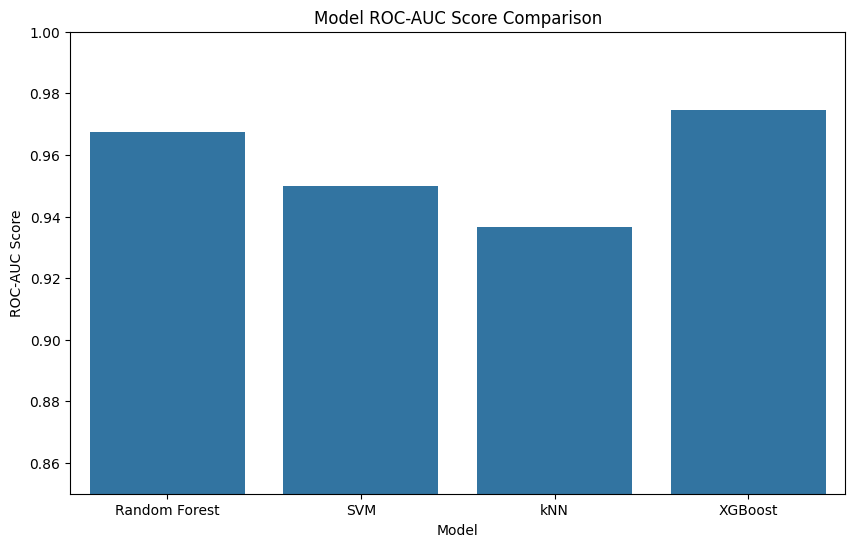

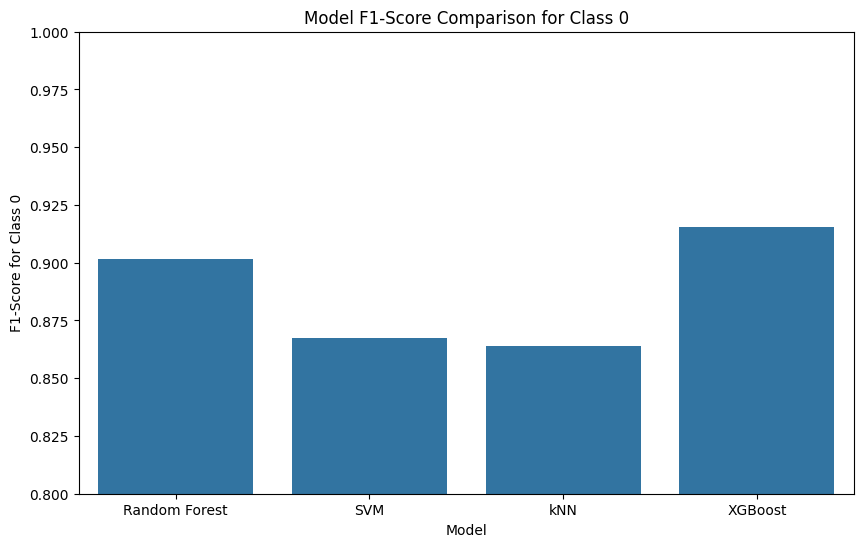

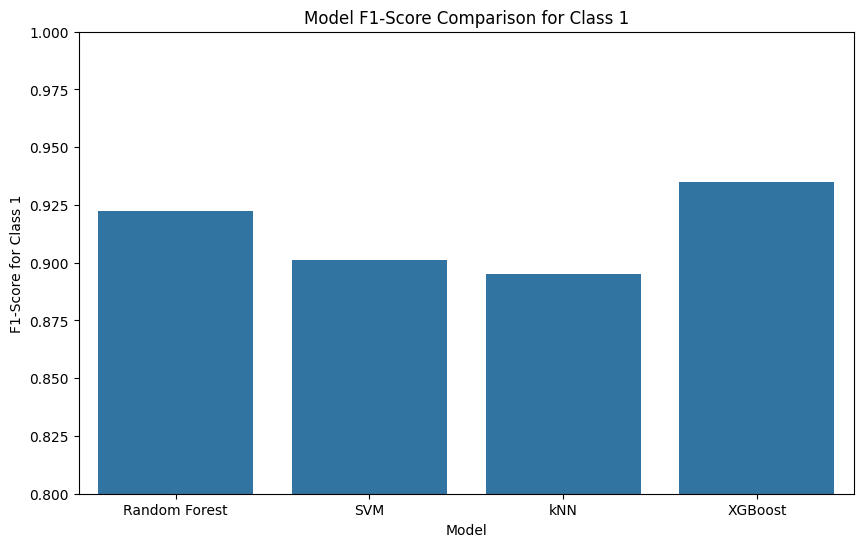

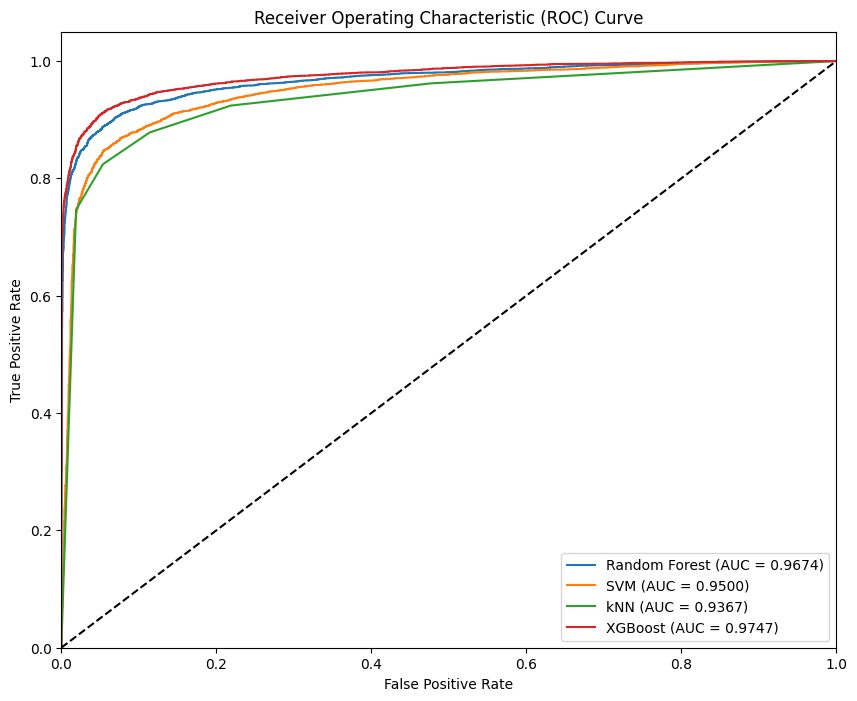

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc

# Collect accuracy scores
accuracy_scores = {
    'Random Forest': float(rf_pipeline.score(X_test, y_test)),
    'SVM': float(svm_pipeline.score(X_test, y_test)),
    'kNN': float(knn_pipeline.score(X_test, y_test)),
    'XGBoost': float(xgb_accuracy.get())
}

# Collect ROC-AUC scores
roc_auc_scores = {
    'Random Forest': float(roc_auc_rf_gpu),
    'SVM': float(roc_auc_svm_gpu),
    'kNN': float(roc_auc_knn_gpu),
    'XGBoost': float(roc_auc_xgb_gpu)
}

# Collect F1-scores for each model
classification_reports = {
    'Random Forest': classification_report(y_test_np, y_pred_rf_np, output_dict=True),
    'SVM': classification_report(y_test_np, y_pred_svm_np, output_dict=True),
    'kNN': classification_report(y_test_np, y_pred_knn_np, output_dict=True),
    'XGBoost': classification_report(y_test_np, y_pred_xgb_np, output_dict=True)
}

f1_scores_0 = {model: report['0']['f1-score'] for model, report in classification_reports.items()}
f1_scores_1 = {model: report['1']['f1-score'] for model, report in classification_reports.items()}

# Plotting Accuracy Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.85, 1.0)  # Set y-axis limits for better comparison
plt.show()

# Plotting ROC-AUC Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()))
plt.xlabel('Model')
plt.ylabel('ROC-AUC Score')
plt.title('Model ROC-AUC Score Comparison')
plt.ylim(0.85, 1.0)  # Set y-axis limits for better comparison
plt.show()

# Plotting F1-Scores for Class 0
plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores_0.keys()), y=list(f1_scores_0.values()))
plt.xlabel('Model')
plt.ylabel('F1-Score for Class 0')
plt.title('Model F1-Score Comparison for Class 0')
plt.ylim(0.8, 1.0)  # Set y-axis limits for better comparison
plt.show()

# Plotting F1-Scores for Class 1
plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores_1.keys()), y=list(f1_scores_1.values()))
plt.xlabel('Model')
plt.ylabel('F1-Score for Class 1')
plt.title('Model F1-Score Comparison for Class 1')
plt.ylim(0.8, 1.0)  # Set y-axis limits for better comparison
plt.show()

# Plotting ROC Curves
def plot_roc_curve(fpr, tpr, model_name):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.4f})')

plt.figure(figsize=(10, 8))

# Random Forest ROC Curve
rf_fpr, rf_tpr, _ = roc_curve(y_test_np, y_pred_rf_proba)
plot_roc_curve(rf_fpr, rf_tpr, 'Random Forest')

# SVM ROC Curve
svm_fpr, svm_tpr, _ = roc_curve(y_test_np, y_pred_svm_proba)
plot_roc_curve(svm_fpr, svm_tpr, 'SVM')

# kNN ROC Curve
knn_fpr, knn_tpr, _ = roc_curve(y_test_np, y_pred_knn_proba)
plot_roc_curve(knn_fpr, knn_tpr, 'kNN')

# XGBoost ROC Curve
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_np, y_pred_xgb_proba)
plot_roc_curve(xgb_fpr, xgb_tpr, 'XGBoost')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


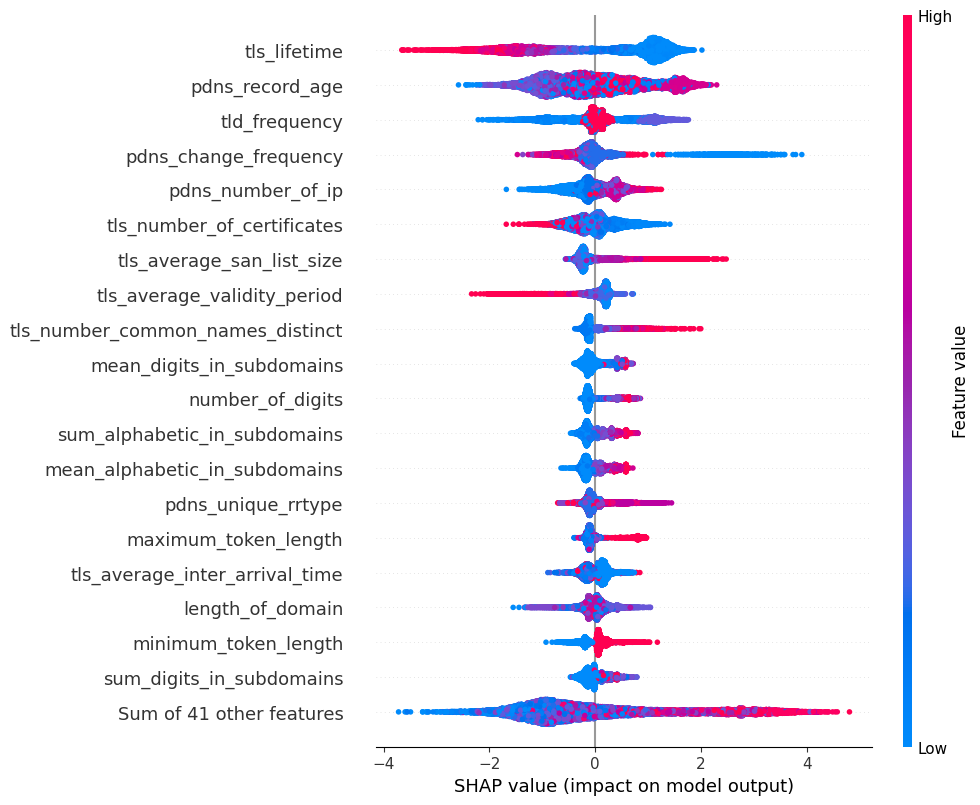

In [ ]:
# Calculate SHAP values and plot for XGBoost (since it the best model)
import sys
sys.path.append('/root/.local/lib/python3.10/site-packages/')

import shap
import cupy as cp

X_train_np = cp.asnumpy(X_train_cupy)
X_test_np = cp.asnumpy(X_test_cupy)

explainer_xgb = shap.explainers.GPUTree(xgb_model, X_train_np)
shap_values_xgb = explainer_xgb(X_test_np)
shap_values_xgb.feature_names = list(X_test.columns)
shap.plots.beeswarm(shap_values_xgb, max_display=20)

In [ ]:
# Save models
import joblib
import os

# Ensure the directory for saving models exists
model_dir = './drive/MyDrive/Colab Notebooks/iteration-v2/models'
os.makedirs(model_dir, exist_ok=True)

# Save the trained models
joblib.dump(rf_pipeline, os.path.join(model_dir, 'v2_rf_pipeline.pkl'))
joblib.dump(svm_pipeline, os.path.join(model_dir, 'v2_svm_pipeline.pkl'))
joblib.dump(knn_pipeline, os.path.join(model_dir, 'v2_knn_pipeline.pkl'))
xgb_model.save_model(os.path.join(model_dir, 'v2_xgb_model.json'))

print("Models saved successfully.")


Models saved successfully.


In [ ]:
# Load saved models
import joblib
import os
import cupy as cp
import xgboost as xgb
from cuml.metrics import roc_auc_score as gpu_roc_auc_score

# Load the saved models
model_dir = './drive/MyDrive/Colab Notebooks/iteration-v2/models'
rf_pipeline_loaded = joblib.load(os.path.join(model_dir, 'v2_rf_pipeline.pkl'))
svm_pipeline_loaded = joblib.load(os.path.join(model_dir, 'v2_svm_pipeline.pkl'))
knn_pipeline_loaded = joblib.load(os.path.join(model_dir, 'v2_knn_pipeline.pkl'))
xgb_model_loaded = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist', device='cuda')
xgb_model_loaded.load_model(os.path.join(model_dir, 'v2_xgb_model.json'))

print("Models loaded successfully.")

# # Make predictions using the loaded models
# y_pred_rf_loaded = rf_pipeline_loaded.predict(X_test)
# y_pred_svm_loaded = svm_pipeline_loaded.predict(X_test)
# y_pred_knn_loaded = knn_pipeline_loaded.predict(X_test)
# y_pred_xgb_loaded = cp.asarray(xgb_model_loaded.predict(X_test_cupy))

# # Predict the probabilities for the positive class (class 1)
# # Get the predicted probabilities for ROC-AUC calculation
# y_pred_rf_proba = rf_pipeline_loaded.predict_proba(X_test).iloc[:, 1].to_numpy()
# y_pred_svm_proba = svm_pipeline_loaded.predict_proba(X_test).iloc[:, 1].to_numpy()
# y_pred_knn_proba = knn_pipeline_loaded.predict_proba(X_test).iloc[:, 1].to_numpy()
# y_pred_xgb_proba = xgb_model_loaded.predict_proba(X_test_cupy)[:, 1]

# # Evaluate the loaded models
# print("Random Forest accuracy (cuML):", rf_pipeline_loaded.score(X_test, y_test))
# print("SVM accuracy (cuML):", svm_pipeline_loaded.score(X_test, y_test))
# print("kNN accuracy (cuML):", knn_pipeline_loaded.score(X_test, y_test))
# print("XGBoost accuracy (cuML):", (y_pred_xgb_loaded == y_test_cupy).mean())

# # Calculate ROC-AUC Score using cuML (GPU)
# # https://www.shiksha.com/online-courses/articles/roc-auc-vs-accuracy
# # Calculate ROC-AUC Scores using cuML (GPU)
# roc_auc_rf_gpu = gpu_roc_auc_score(y_test_cupy, cp.asarray(y_pred_rf_proba))
# roc_auc_svm_gpu = gpu_roc_auc_score(y_test_cupy, cp.asarray(y_pred_svm_proba))
# roc_auc_knn_gpu = gpu_roc_auc_score(y_test_cupy, cp.asarray(y_pred_knn_proba))
# roc_auc_xgb_gpu = gpu_roc_auc_score(y_test_cupy, y_pred_xgb_proba)

# print("\n\nRandom Forest ROC-AUC Score (GPU):", roc_auc_rf_gpu)
# print("SVM ROC-AUC Score (GPU):", roc_auc_svm_gpu)
# print("kNN ROC-AUC Score (GPU):", roc_auc_knn_gpu)
# print("XGBoost ROC-AUC Score (GPU):", roc_auc_xgb_gpu)

# # Convert cuDF Series to NumPy arrays for classification_report
# y_pred_rf_loaded_np = y_pred_rf_loaded.to_numpy()
# y_pred_svm_loaded_np = y_pred_svm_loaded.to_numpy()
# y_pred_knn_loaded_np = y_pred_knn_loaded.to_numpy()
# y_pred_xgb_loaded_np = cp.asnumpy(y_pred_xgb_loaded)  # Convert CuPy array to NumPy array
# y_pred_xgb_proba_np = cp.asnumpy(y_pred_xgb_proba)  # Convert CuPy array to NumPy array for probabilities

# # Evaluate Random Forest
# print("\n\nRandom Forest Classification Report (loaded model):")
# print(classification_report(y_test_np, y_pred_rf_loaded_np))

# # Evaluate SVM
# print("SVM Classification Report (loaded model):")
# print(classification_report(y_test_np, y_pred_svm_loaded_np))

# # Evaluate kNN
# print("kNN Classification Report (loaded model):")
# print(classification_report(y_test_np, y_pred_knn_loaded_np))

# # Evaluate XGBoost
# print("XGBoost Classification Report (loaded model):")
# print(classification_report(y_test_np, y_pred_xgb_loaded_np))

Models loaded successfully.
